In [1]:
!pip install --user -U ..

Processing /home/nathan/workspace/transfer-style
  Created wheel for transferutils: filename=transferutils-0.0.2-cp36-none-any.whl size=6091 sha256=706ddb0419921d477c6f97a6baa765bffb7c5d4cdf25c10c040717472b176feb
  Stored in directory: /home/nathan/.cache/pip/wheels/b8/97/a6/85e4f02f381d38fe0c42e053c3727b326b4c736667f55e65e7
Successfully built transferutils
  Found existing installation: transferutils 0.0.1
    Uninstalling transferutils-0.0.1:
      Successfully uninstalled transferutils-0.0.1


In [2]:
from typing import Sequence, Tuple

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.applications import VGG19
from PIL import Image
from tqdm import tqdm

import transferutils as tu

STYLE_PATH = "../data/style"
CONTENT_PATH = "../data/content"

IMAGE_SHAPE = (512, 512, 3)

In [3]:
style_img = tu.import_transform(f"{STYLE_PATH}/vangogh.png")
content_img = tu.import_transform(f"{CONTENT_PATH}/ensc.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


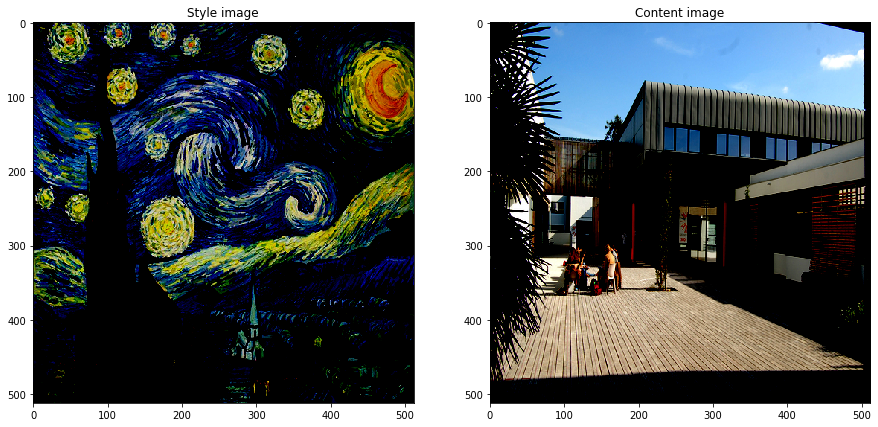

In [4]:
fig = plt.figure(figsize=(15, 10))

axes = fig.add_subplot(1, 2, 1)
axes.imshow(np.squeeze(style_img))
axes.set_title("Style image")

axes = fig.add_subplot(1, 2, 2)
axes.imshow(np.squeeze(content_img))
axes.set_title("Content image")

plt.show(fig)

In [5]:
vgg_max = VGG19(include_top=False,  weights='imagenet', input_shape=IMAGE_SHAPE)
vgg_max.trainable = False
vgg = tu.replace_max_by_average_pooling(vgg_max)
vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, 128, 128, 128)     0     

In [14]:
content_blocks = [tu.get_vgg_layer(vgg, f"block{i}_conv1", f"block{i}") for i in range(1, 6)]
style_blocks = [[content_blocks[j] for j in range(i)] for i in range(1, len(content_blocks) + 1)]

In [15]:
def compute_loss(alpha: float,
                 style_layers: Sequence[keras.models.Model],
                 content_layer: keras.models.Model,
                 init_noise: tf.Variable,
                 style_features: tf.Tensor,
                 content_features: tf.Tensor):
    
    style_score = tu.compute_style_loss(style_layers, init_noise, style_features)
    content_score = tu.compute_content_loss(content_layer, init_noise, content_features)
    
    loss = alpha * style_score + (1.0 - alpha) * content_score
    
    return loss, content_score, style_score

In [27]:
def compute_grads(**kwargs):
    with tf.GradientTape() as tape:
        tape.watch(kwargs.get("init_noise"))
        loss, content_score, style_score = compute_loss(**kwargs)
        return tape.gradient(loss, kwargs.get("init_noise")), loss, content_score, style_score

In [78]:
def train_style_transfer(style_blocks: Sequence[tf.keras.models.Model],
                         content_block: tf.keras.models.Model,
                         style_img: np.ndarray,
                         content_img: np.ndarray,
                         iterations=500,
                         alpha=0.0001,
                         opt=tf.keras.optimizers.Adam(5, decay=1e-3)):

    with tf.device("GPU:0"):
        style_features = []
        for block in style_blocks:
            style_features.append(block(style_img))
            
        content_features = content_block(content_img)
        
        init_noise = tf.Variable(tf.random.normal([1, *IMAGE_SHAPE])) #WARNING: toujours mettre les trucs utilisés par le
                                                                      #GradientTape en tf.Variable ("mutable tensor") sinon c'est 
                                                                      #la hez
        #init_noise = tf.Variable(content_img)
        
        min_vals = -1
        max_vals = 1

        loss_history = []
        style_history = []
        content_history = []
        built_imgs = []
        best_loss = float("inf")
        
        for i in tqdm(range(iterations), f"Building img"):
            grads, loss, content_score, style_score = compute_grads(alpha=alpha, 
                                                                    style_layers=style_blocks, 
                                                                    content_layer=content_block,
                                                                    init_noise=init_noise,
                                                                    content_features=content_features,
                                                                    style_features=style_features)
            opt.apply_gradients([(grads, init_noise)])          
            clipped = tf.clip_by_value(init_noise, min_vals, max_vals)
            init_noise.assign(clipped) 
            
            loss_history.append(loss.numpy())
            style_history.append(style_score.numpy())
            content_history.append(content_score.numpy())

            if loss < best_loss:
                best_loss = loss
                built_imgs.append(np.squeeze(init_noise.numpy().copy()))
                
    return {"loss": loss_history, "style": style_history, "content": content_history}, built_imgs

In [79]:
history, imgs = train_style_transfer(style_blocks[2], content_blocks[-1], style_img, content_img)

Building img: 100%|██████████| 500/500 [01:05<00:00,  7.61it/s]


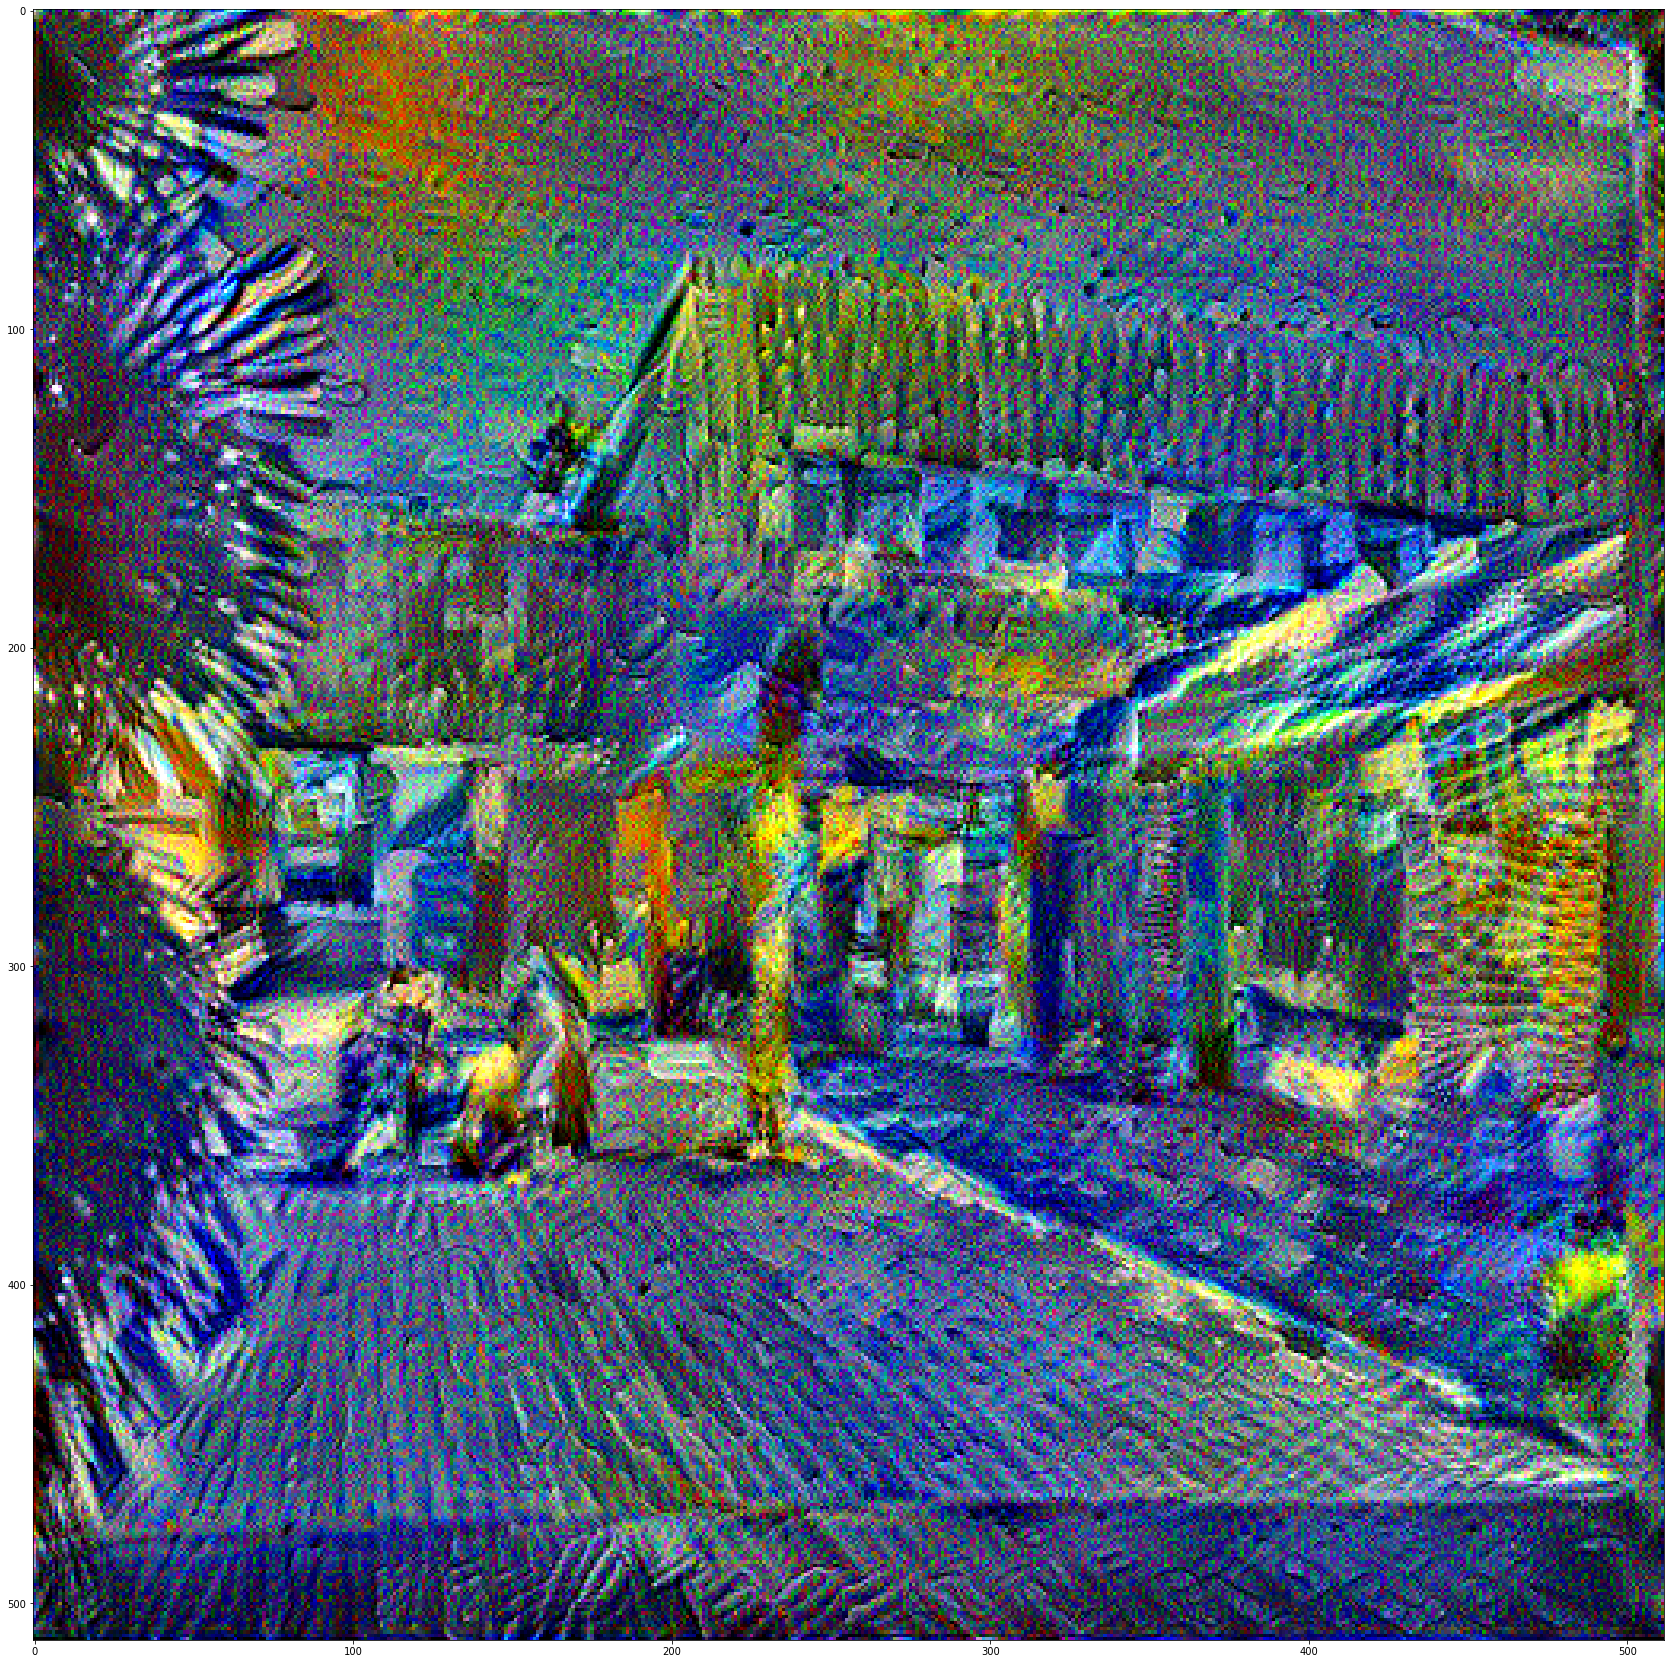

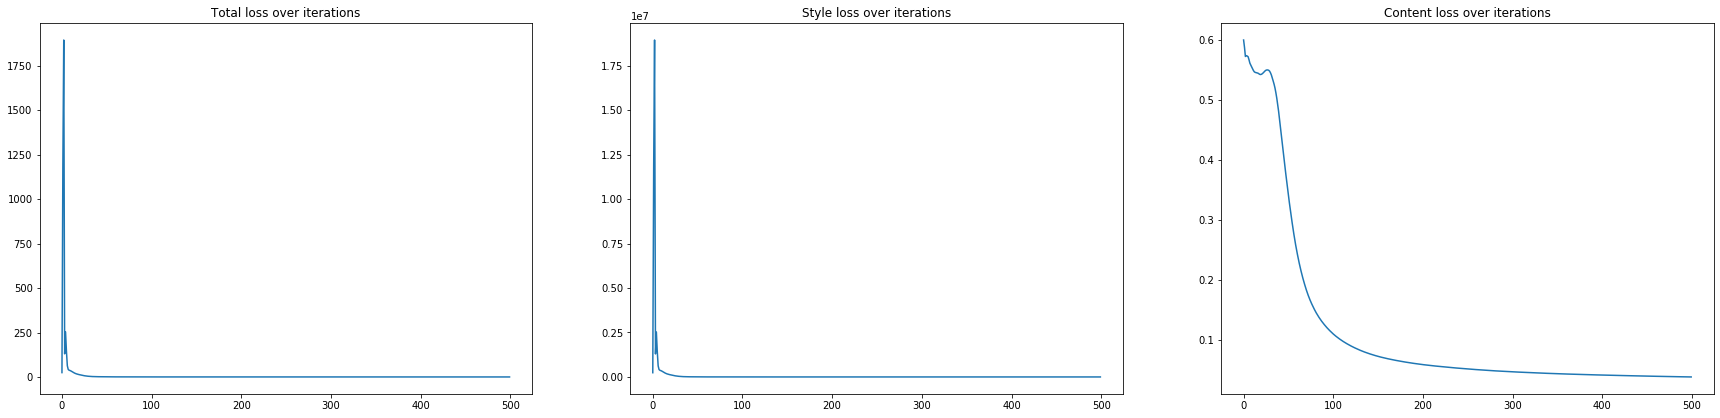

In [82]:
fig0 = plt.figure(figsize=(30, 30))

axes = fig0.add_subplot(1, 1, 1)
axes.imshow(tu.deprocess_img(imgs[-1]))

fig0.show()

fig = plt.figure(figsize=(30, 15))

axes2 = fig.add_subplot(2, 3, 4)
axes2.plot(history["loss"])
axes2.set_title("Total loss over iterations")

axes3 = fig.add_subplot(2, 3, 5)
axes3.plot(history["style"])
axes3.set_title("Style loss over iterations")

axes4 = fig.add_subplot(2, 3, 6)
axes4.plot(history["content"])
axes4.set_title("Content loss over iterations")

fig.show()

In [83]:
fig0.savefig("../reports/style_transfer.png")
fig.savefig("../reports/style_transfer_metrics.png")